In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle


import keras
from keras.layers import InputLayer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler

import util.items as items

Using TensorFlow backend.


In [2]:
item = 'Yew_logs'

In [3]:
items.getItemPrices(item)[-10:]

[293, 290, 289, 289, 290, 292, 290, 286, 281, 277]

In [4]:
items.getItemInfo(item)

{'members': 'False',
 'edible': 'False',
 'update': '/w/Update:Latest_RuneScape_News_(25_March_2002)',
 'quest': 'No',
 'destroy': 'Drop',
 'image': '/w/File:Yew_logs.png',
 'lowAlch': '64',
 'examine': 'Logs cut from a yew tree',
 'highAlch': '96',
 'storeprice': 'N/A',
 'seller': 'N/A',
 'equipable': 'False',
 'weight': '2.0',
 'released': '25 March 2002',
 'storeCurrency': 'N/A',
 'name': 'Yew_logs',
 'alchable': 'True',
 'exchangePrice': '271',
 'tradeable': 'True',
 'buyLimit': '12000',
 'noteable': 'True',
 'stackable': 'False'}

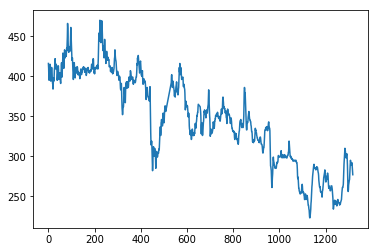

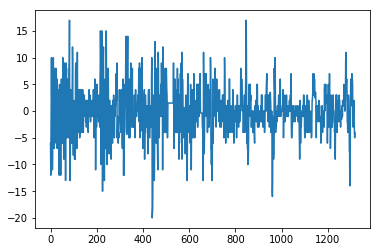

In [5]:
prices = items.getItemPrices(item)
changes = items.getPriceChanges(item)
plt.plot(prices)
plt.show()
plt.plot(changes)
plt.show()

In [6]:
def minMax(data):
    d = []
    ma = max(data)
    mi = min(data)
    for i in range(len(data)):
        d.append((data[i]-mi)/(ma-mi))
    return d

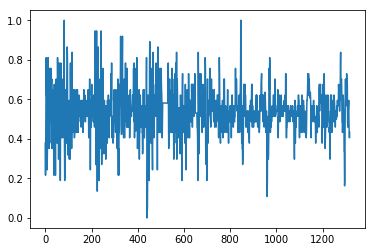

In [7]:
s_changes = minMax(changes)
plt.plot(s_changes)
plt.show()

In [8]:
x = []
for i in range(len(s_changes)-5):
    x.append(s_changes[i:i+5])
print(x[0],x[-1])

[0.3783783783783784, 0.21621621621621623, 0.4594594594594595, 0.6216216216216216, 0.8108108108108109] [0.5675675675675675, 0.5945945945945946, 0.4864864864864865, 0.43243243243243246, 0.40540540540540543]


In [9]:
y = []
p = []
for i in range(5,len(s_changes)):
    y.append(s_changes[i])
    p.append(prices[i])
print(y[0],y[1],y[-2],y[-1])

0.6216216216216216 0.6486486486486487 0.40540540540540543 0.43243243243243246


In [10]:
s1 = int(len(y)*.7)
s2  =int(len(y)*.85)
x_train = np.array(x[:s1])
y_train = np.array(y[:s1])
x_val = np.array(x[s1:s2])
y_val = np.array(y[s1:s2])
x_test = np.array(x[s2:])
y_test = np.array(y[s2:])
p_test = np.array(p[s2:])
print(len(x_train),len(y_train),len(x_val),len(y_val),len(x_test),len(y_test),len(p_test))
print(x_train[0],y_train[0],x_test[0],y_test[0])

919 919 197 197 197 197 197
[0.37837838 0.21621622 0.45945946 0.62162162 0.81081081] 0.6216216216216216 [0.56756757 0.59459459 0.56756757 0.56756757 0.51351351] 0.4864864864864865


In [11]:
model = Sequential()
model.add(Dense(5, input_dim=5))
model.add(Dense(5, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='linear'))

In [12]:
sgd = SGD(lr=0.1)
model.compile(loss='mse',
              optimizer=sgd,
              metrics=['mse'])

history = model.fit(x_train, y_train,
            validation_data=(x_val,y_val),
            epochs=10,
            batch_size=1)
score = model.evaluate(x_test, y_test, batch_size=1)
print(score)

Train on 919 samples, validate on 197 samples
Epoch 1/10


InternalError: Blas GEMM launch failed : a.shape=(1, 5), b.shape=(5, 5), m=1, n=5, k=5
	 [[{{node dense_1/MatMul}} = MatMul[T=DT_FLOAT, _class=["loc:@training/SGD/gradients/dense_1/MatMul_grad/MatMul_1"], transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_dense_1_input_0_0/_45, dense_1/kernel/read)]]
	 [[{{node loss/mul/_65}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_317_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


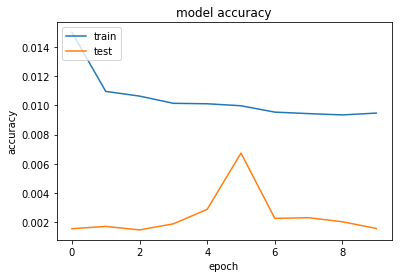

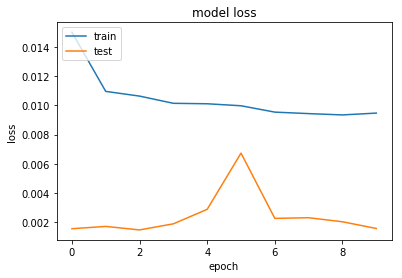

In [55]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

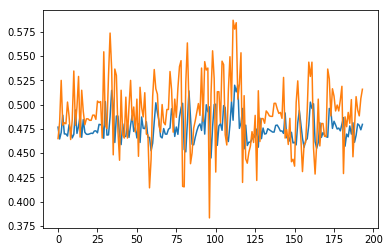

In [56]:
y_pred = model.predict(x_test)
plt.plot(y_pred)
plt.plot(y_test)
plt.show()

In [57]:
import util.trading_systems as ts

In [58]:
bl = int(items.getItemInfo(item)['buyLimit'])
print(len(x_test))
budgets = [10**5,10**6,10**7,10**8,10**9]
mpBest = [([-100],-1)] * len(budgets)
ppBest = [([-100],-1)] * len(budgets)
bhBest = [([-100],-1)] * len(budgets)
for b in range(len(budgets)):
    print(budgets[b])
    t = 0
    bhBest[b] = ts.buyAndHold(p_test,bl,budgets[b])
    for i in range(10):
        mp = ts.modelProfit(x_test,t,model,p_test,bl,budgets[b])
        if mp[-1]>mpBest[b][0][-1] and mp[-1]!=0.0:
            mpBest[b] = (mp,t)
        pp = ts.perfectProfit(x_test,t,y_test,p_test,bl,budgets[b])
        if pp[-1]>ppBest[b][0][-1]:
            ppBest[b] = (pp,t)
        t += .02

194
100000


1000000


10000000


100000000


1000000000


In [60]:
for b in range(len(budgets)):
    print(budgets[b])
    print('\tModel\n\t',mpBest[b][0][-1],mpBest[b][1])
    print('\tPerfect\n\t',ppBest[b][0][-1],ppBest[b][1])
    print('\tBuy and Hold\n\t',bhBest[b][-1])

100000
	Model
	 0.00481 0.04
	Perfect
	 0.4622 0
	Buy and Hold
	 -0.00468
1000000
	Model
	 0.00259 0.04
	Perfect
	 0.31449 0
	Buy and Hold
	 -0.00252
10000000
	Model
	 0.000259 0.04
	Perfect
	 0.033824 0
	Buy and Hold
	 -0.000252
100000000
	Model
	 2.59e-05 0.04
	Perfect
	 0.0033824 0
	Buy and Hold
	 -2.52e-05
1000000000
	Model
	 2.59e-06 0.04
	Perfect
	 0.00033824 0
	Buy and Hold
	 -2.52e-06


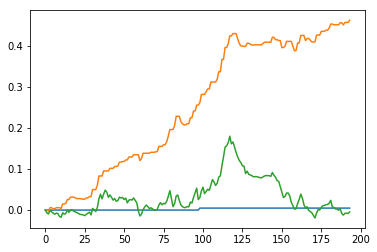

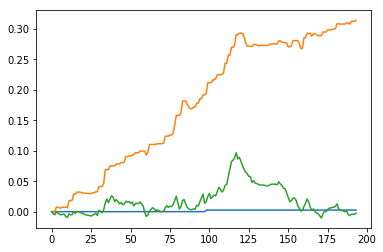

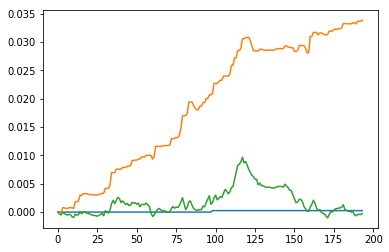

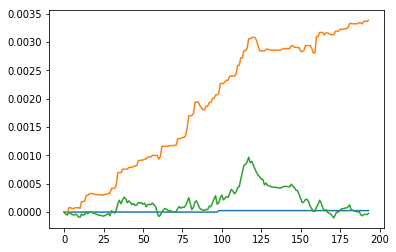

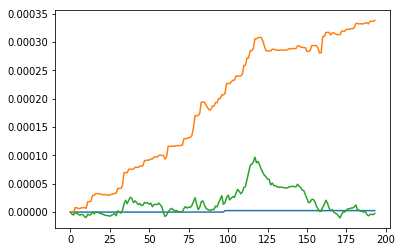

In [61]:
for b in range(len(budgets)):
    plt.plot(mpBest[b][0])
    plt.plot(ppBest[b][0])
    plt.plot(bhBest[b])
    plt.show()